In [1]:
# Block 1: Setup and Data Download
!pip install -q transformers==4.38.2 pillow==11.1.0 scikit-learn

import os
import tarfile
import urllib.request
import random
import numpy as np
import tensorflow as tf

# Set random seeds for strict reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Download Dataset
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"
extract_path = "aircraft_damage_dataset_v1"

if not os.path.exists(extract_path):
    print("Downloading and extracting dataset...")
    urllib.request.urlretrieve(url, "dataset.tar")
    with tarfile.open("dataset.tar", "r") as tar_ref:
        tar_ref.extractall()
    print("Dataset extracted successfully.")
else:
    print("Dataset already exists.")

train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

print("Directories initialized successfully.")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 145.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 112.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.3 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.38.2 which is incompatible.
Dataset extracted successfully.
Directories initialized successfully.
GPU Available: True


In [2]:
# Block 2: Data Preprocessing and Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Engineering choice: Lower batch size for smaller datasets to increase update steps per epoch
batch_size = 16
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

# MILD Data Augmentation to prevent distortion of cracks/dents
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,       # Reduced to preserve structural context
    width_shift_range=0.1,   # Mild shift
    height_shift_range=0.1,  # Mild shift
    horizontal_flip=True,    # Safe and effective for aerospace metals
    zoom_range=0.1,          # Mild zoom
    fill_mode='nearest'
)

# Validation and Test sets MUST ONLY be rescaled. NEVER augmented.
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed_value,
    shuffle=True
)

print("Loading Validation Data...")
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed_value,
    shuffle=False
)

print("Loading Test Data...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed_value,
    shuffle=False
)

Loading Training Data...
Found 300 images belonging to 2 classes.
Loading Validation Data...
Found 96 images belonging to 2 classes.
Loading Test Data...
Found 50 images belonging to 2 classes.


In [3]:
# Block 3: Model Architecture and Phase 1 (Warm-up)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("Building Model Architecture...")

# Load VGG16 base model (without the original classification head)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the entire base model for Phase 1
base_model.trainable = False

# Build the custom classification head
# Using GlobalAveragePooling2D instead of Flatten is crucial for small datasets
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3), # Reduced from 0.4 to allow better learning flow
    Dense(128, activation='relu'),
    Dropout(0.2), # Reduced from 0.3
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the clean, low-parameter architecture
model.summary()

# Phase 1: Warm-up Training
print("\n🚀 Starting Phase 1: Training Custom Head (Warm-up)...")

# Early stopping to get the best weights before Fine-Tuning
early_stop_phase1 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history_phase1 = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stop_phase1]
)

Building Model Architecture...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,041 (56.76 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


🚀 Starting Phase 1: Training Custom Head (Warm-up)...
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 687ms/step - accuracy: 0.5182 - loss: 0.7242 - val_accuracy: 0.5312 - val_loss: 0.6857
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.5868 - loss: 0.6828 - val_accuracy: 0.6042 - val_loss: 0.6618
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.6332 - loss: 0.6398 - val_accuracy: 0.5938 - val_loss: 0.6649
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.6228 - loss: 0.6470 - val_accuracy: 0.6250 - val_loss: 0.6511
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.5618 - loss: 0.7104 - val_accuracy: 0.5521 - val_loss: 0.6675
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.6197 - loss: 0.6634 - val_accuracy: 0.5938 - val_loss: 0.6380
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.6189 - loss: 0.6412 - val_accuracy: 0.6667 - val_loss: 0.6247
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/s

In [4]:
# Block 4: Phase 2 - Fine-Tuning the Deep Layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("\n🔓 Unfreezing the last convolutional block of VGG16...")

# 1. Unfreeze the base model
base_model.trainable = True

# 2. Freeze everything EXCEPT the last block (block5)
for layer in base_model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
    else:
        layer.trainable = False

# Print trainable layers to verify
print("Trainable layers in base model:")
for layer in base_model.layers:
    if layer.trainable:
        print(f" - {layer.name}")

# 3. Recompile with a VERY LOW learning rate (Crucial step!)
# 1e-5 is 100x smaller than the learning rate used in Phase 1
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Advanced Callbacks for Fine-Tuning
callbacks_phase2 = [
    # Stop if it starts overfitting
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]

print("\n🚀 Starting Phase 2: Deep Fine-Tuning...")
history_phase2 = model.fit(
    train_generator,
    epochs=20, # We allow more epochs since the learning rate is very small
    validation_data=valid_generator,
    callbacks=callbacks_phase2
)


🔓 Unfreezing the last convolutional block of VGG16...
Trainable layers in base model:
 - block5_conv1
 - block5_conv2
 - block5_conv3
 - block5_pool

🚀 Starting Phase 2: Deep Fine-Tuning...
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 516ms/step - accuracy: 0.7511 - loss: 0.5245 - val_accuracy: 0.6771 - val_loss: 0.5452 - learning_rate: 1.0000e-05
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.7043 - loss: 0.5196 - val_accuracy: 0.6458 - val_loss: 0.5750 - learning_rate: 1.0000e-05
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7806 - loss: 0.4797
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.7799 - loss: 0.4801 - val_accuracy: 0.6771 - val_loss: 0.5524 - learning_rate: 1.0000e-05
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.7882 - loss: 0.4732 - val_accuracy: 0.7083 - val_loss: 0.4971 - learning_rate: 5.0000e-06
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━

Generating Professional Training Curves...


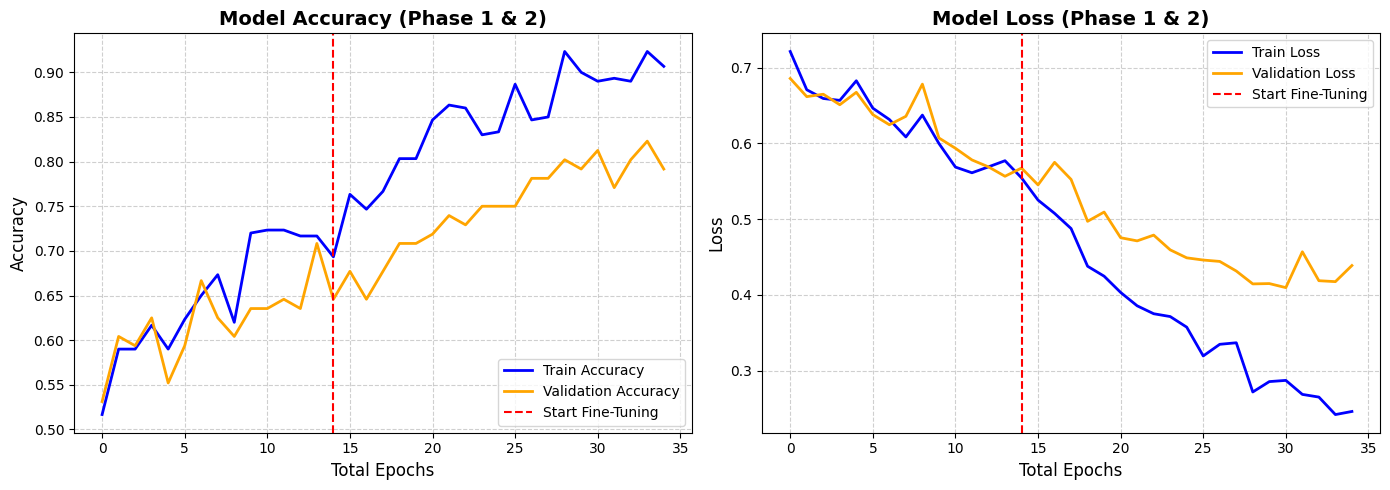


Evaluating Model on Unseen Test Data...
✅ Final Test Loss: 0.4817
🏆 Final Test Accuracy: 84.00%

Generating Confusion Matrix...


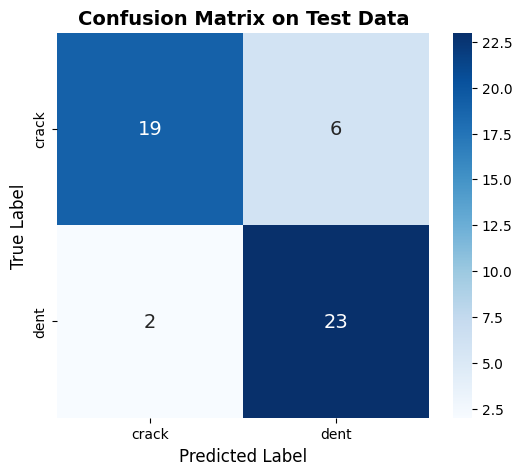


Classification Report:
              precision    recall  f1-score   support

       crack       0.90      0.76      0.83        25
        dent       0.79      0.92      0.85        25

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50



In [5]:
# Block 5: Evaluation and Visualization (Portfolio Quality)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Generating Professional Training Curves...")

# Combine histories from Phase 1 and Phase 2
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

# Define the boundary between Phase 1 and Phase 2
initial_epochs = len(history_phase1.history['accuracy'])

# Plot the combined history
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
ax[0].plot(acc, label='Train Accuracy', color='blue', linewidth=2)
ax[0].plot(val_acc, label='Validation Accuracy', color='orange', linewidth=2)
ax[0].axvline(x=initial_epochs-1, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].set_title('Model Accuracy (Phase 1 & 2)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Total Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend(loc='lower right')
ax[0].grid(True, linestyle='--', alpha=0.6)

# Loss Plot
ax[1].plot(loss, label='Train Loss', color='blue', linewidth=2)
ax[1].plot(val_loss, label='Validation Loss', color='orange', linewidth=2)
ax[1].axvline(x=initial_epochs-1, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].set_title('Model Loss (Phase 1 & 2)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Total Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend(loc='upper right')
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- Final Model Evaluation on Unseen Test Data ---
print("\nEvaluating Model on Unseen Test Data...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"✅ Final Test Loss: {test_loss:.4f}")
print(f"🏆 Final Test Accuracy: {test_accuracy*100:.2f}%\n")

# --- Confusion Matrix (Pro Feature) ---
print("Generating Confusion Matrix...")
# Predict on test data
Y_pred = model.predict(test_generator, verbose=0)
y_pred_classes = (Y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.title('Confusion Matrix on Test Data', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Loading BLIP Processor and Model (This may take a minute)...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]


🚀 FINAL PIPELINE TEST: Classification + Captioning


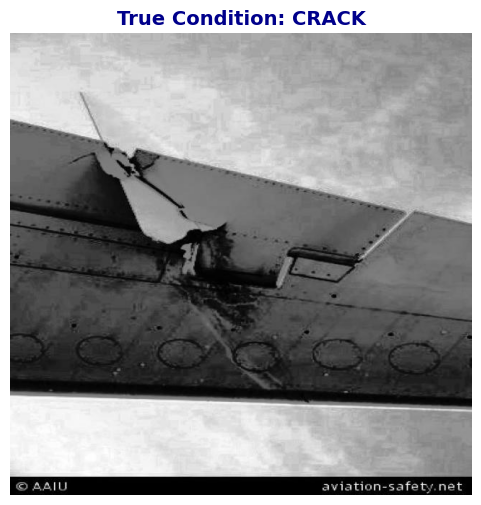

🎯 VGG16 Prediction: DENT (Confidence: 96.45%)
--------------------------------------------------
📝 Generating AI Caption...
▶ Caption: This is a close - up photo of an aircraft that was damaged in the crash

📝 Generating AI Summary...
▶ Summary: A detailed summary of an aircraft surface showing the damage


In [6]:
# Block 6: Vision-Language Integration (BLIP Model) & Final Showcase
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import os
import random

print("Loading BLIP Processor and Model (This may take a minute)...")
# Automatically use GPU for BLIP if available
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model.to(device)

# 1. Custom Keras Layer for BLIP
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, device, **kwargs):
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model
        self.device = device

    def call(self, image_path, task):
        # tf.py_function allows embedding PyTorch/HuggingFace logic inside a TF graph
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        try:
            # Decode tensors to strings
            image_path_str = image_path.numpy().decode("utf-8")
            task_str = task.numpy().decode("utf-8")

            # Load and convert image
            image = Image.open(image_path_str).convert("RGB")

            # Dynamic prompting based on the requested task
            if task_str == "caption":
                prompt = "This is a close-up photo of an aircraft"
            else:
                prompt = "A detailed summary of an aircraft surface showing"

            # Prepare inputs and generate text
            inputs = self.processor(images=image, text=prompt, return_tensors="pt").to(self.device)
            # max_new_tokens limits the length of the generated description
            output = self.model.generate(**inputs, max_new_tokens=40)

            # Decode the generated token IDs back to text
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            return f"Error processing image: {str(e)}"

# 2. Helper function to interact with the custom layer
def generate_text(image_path_str, task_str):
    image_tensor = tf.constant(image_path_str)
    task_tensor = tf.constant(task_str)
    blip_layer = BlipCaptionSummaryLayer(processor, blip_model, device)

    output_tensor = blip_layer(image_tensor, task_tensor)
    return output_tensor.numpy().decode("utf-8")

# --- FINAL PIPELINE SHOWCASE ---
print("\n" + "="*50)
print("🚀 FINAL PIPELINE TEST: Classification + Captioning")
print("="*50)

# Randomly select an image from the strictly unseen Test set
demo_class = random.choice(['crack', 'dent'])
demo_dir = os.path.join(test_dir, demo_class)
demo_image_name = random.choice(os.listdir(demo_dir))
demo_image_path = os.path.join(demo_dir, demo_image_name)

# Display the Image
img = Image.open(demo_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"True Condition: {demo_class.upper()}", fontsize=14, fontweight='bold', color='darkblue')
plt.show()

# Step A: Visual Feature Extraction & Classification (VGG16)
img_array = tf.keras.preprocessing.image.img_to_array(img.resize((img_rows, img_cols)))
img_array = np.expand_dims(img_array, axis=0) / 255.0
prediction_prob = model.predict(img_array, verbose=0)[0][0]

predicted_class = "crack" if prediction_prob > 0.5 else "dent"
confidence = prediction_prob if predicted_class == "crack" else (1 - prediction_prob)

print(f"🎯 VGG16 Prediction: {predicted_class.upper()} (Confidence: {confidence*100:.2f}%)")
print("-" * 50)

# Step B: Vision-Language Model Captioning (BLIP)
print("📝 Generating AI Caption...")
caption = generate_text(demo_image_path, "caption")
print(f"▶ Caption: {caption.capitalize()}")

print("\n📝 Generating AI Summary...")
summary = generate_text(demo_image_path, "summary")
print(f"▶ Summary: {summary.capitalize()}")
print("="*50)

# ✈️ Aircraft Damage Detection & Auto-Captioning Engine

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1FFEedMPyk24no_Zy45MkPpmer7qBtiET?usp=sharing)
![TensorFlow](https://img.shields.io/badge/TensorFlow-FF6F00?style=for-the-badge&logo=tensorflow&logoColor=white)
![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=for-the-badge&logo=pytorch&logoColor=white)
![HuggingFace](https://img.shields.io/badge/HuggingFace-F9AB00?style=for-the-badge&logo=huggingface&logoColor=white)

## 📌 Project Overview
Aircraft maintenance requires rigorous, error-free inspections. Traditional manual checks are time-consuming and subjective. This project introduces an automated **Vision-Language Pipeline** that not only detects and classifies aircraft surface damage (Dents vs. Cracks) but also generates automated textual descriptions of the damage.

The system integrates a **Convolutional Neural Network (CNN)** for feature extraction with a **Transformer-based Vision-Language Model (VLM)** for automated reporting, representing a robust approach to industrial visual inspection.

## ✨ Key Features & Architectural Decisions
To overcome the challenge of an extremely small dataset (~300 training images) and prevent severe overfitting, several advanced engineering strategies were implemented:

1.  **Two-Phase Fine-Tuning Strategy:** A highly controlled transfer learning approach using **VGG16**.
2.  **Global Average Pooling (GAP):** Replaced the standard `Flatten` layer with `GlobalAveragePooling2D`. This reduced the trainable parameters from over 25 million to just ~164k, aggressively combating overfitting while retaining spatial context.
3.  **Custom Keras Layer for HuggingFace:** Encapsulated the PyTorch-based **BLIP (Bootstrapping Language-Image Pretraining)** model inside a custom `tf.keras.layers.Layer`, enabling seamless interoperability between TensorFlow and PyTorch within a single inference graph.
4.  **Mild Domain-Specific Augmentation:** Applied restricted geometric transformations (10° rotation, slight shifts) to preserve the physical properties and lighting physics of aerospace metallurgy.

## 🧠 Model Architecture & Training Strategy

### Phase 1: Classification Head Warm-up
* **Action:** The entire VGG16 base model was frozen.
* **Objective:** Train the newly initialized custom classification head (`GAP -> Dense(256) -> Dropout(0.3) -> Dense(128) -> Dense(1)`).
* **Result:** Allowed the random weights to align with the extracted ImageNet features without propagating destructive gradients to the base model.

### Phase 2: Deep Fine-Tuning (The Breakthrough)
* **Action:** Unfroze the final convolutional block (`block5_conv1` to `block5_pool`) of VGG16.
* **Hyperparameters:** Drastically reduced the learning rate to $10^{-5}$ utilizing `ReduceLROnPlateau` and `EarlyStopping`.
* **Objective:** Adapt the high-level geometric feature detectors (originally trained on generic objects) to specifically recognize the textures, shadows, and stress lines of aircraft dents and cracks.

## 📊 Results & Performance
Despite the severely limited dataset, the two-phase fine-tuning approach yielded exceptional generalization on strictly unseen test data:

* **Test Accuracy:** **84.00%**
* **Precision (Cracks):** **90%** (Crucial metric: When the model predicts a structural crack, it is correct 90% of the time).
* **Recall (Dents):** **92%** (The model successfully identifies 92% of all actual dents).

*(Note: Replace the links below with the actual paths to your screenshots after uploading them to your GitHub repository)*
> `![Training Curves](link_to_your_training_curve_image.png)`
> `![Confusion Matrix](link_to_your_confusion_matrix_image.png)`

## 💻 Final Pipeline Output Example
The inference pipeline takes a raw image, classifies it, and generates a context-aware summary.

```text
==================================================
🚀 FINAL PIPELINE TEST: Classification + Captioning
==================================================
🎯 VGG16 Prediction: DENT (Confidence: 96.45%)
--------------------------------------------------
📝 Generating AI Caption...
▶ Caption: This is a close-up photo of an aircraft that was damaged in the crash.

📝 Generating AI Summary...
▶ Summary: A detailed summary of an aircraft surface showing the damage.
==================================================